In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (train_test_split,
                                     cross_val_score, KFold, GridSearchCV)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix)
from imutils import paths
import cv2
import os
import numpy as np
import argparse
import matplotlib.pyplot as plt
import pandas as pd
import requests
import zipfile
import io
import os

In [3]:
url = "https://github.com/10sajan10/CS6830_Project7/raw/main/sateliteimage.zip"

response = requests.get(url)
if response.status_code == 200:
    print("Download successful!")
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall()
        print(f"Files extracted")

Download successful!
Files extracted


In [4]:
def extract_color_stats(image):

    B, G, R = cv2.split(image)

    mean_R, mean_G, mean_B = np.mean(R), np.mean(G), np.mean(B)
    std_R, std_G, std_B = np.std(R), np.std(G), np.std(B)

    features = [mean_R, mean_G, mean_B, std_R, std_G, std_B]

    return features

In [5]:
imagePaths = paths.list_images(r'sateliteimage/')
data = []
labels_str = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    features = extract_color_stats(image)
    data.append(features)

    # extract the class label from the file path and update the labels list
    label = imagePath.split(os.path.sep)[-2].split("/")[1]
    labels_str.append(label)

le = LabelEncoder()
labels = le.fit_transform(labels_str)

In [6]:
labels_str

['cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',
 'cloudy',

In [7]:
df = pd.DataFrame(data, columns=['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'])
df['label'] = labels_str

NameError: name 'sns' is not defined

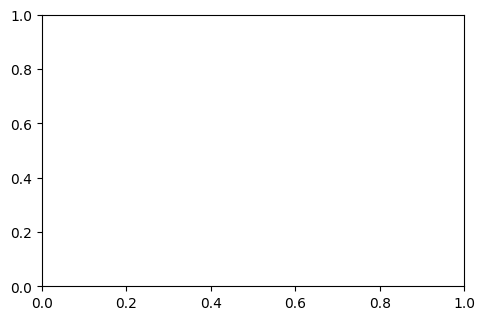

In [8]:
plt.figure(figsize=(12, 12))

# Plot for mean(R)
plt.subplot(3, 2, 1)
sns.histplot(data=df, x='mean_R', hue='label', kde=True)
plt.title('Distribution of Mean Red (R) Channel')

# Plot for std(R)
plt.subplot(3, 2, 2)
sns.histplot(data=df, x='std_R', hue='label', kde=True)
plt.title('Distribution of Std Red (R) Channel')

# Plot for mean(G)
plt.subplot(3, 2, 3)
sns.histplot(data=df, x='mean_G', hue='label', kde=True)
plt.title('Distribution of Mean Green (G) Channel')

# Plot for std(G)
plt.subplot(3, 2, 4)
sns.histplot(data=df, x='std_G', hue='label', kde=True)
plt.title('Distribution of Std Green (G) Channel')

# Plot for mean(B)
plt.subplot(3, 2, 5)
sns.histplot(data=df, x='mean_B', hue='label', kde=True)
plt.title('Distribution of Mean Blue (B) Channel')

# Plot for std(B)
plt.subplot(3, 2, 6)
sns.histplot(data=df, x='std_B', hue='label', kde=True)
plt.title('Distribution of Std Blue (B) Channel')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 12))

# Plot for mean_R vs mean_G
plt.subplot(3, 1, 1)
sns.scatterplot(data=df, x='mean_R', y='mean_G', hue='label')
plt.title('Mean Red (R) vs. Mean Green (G)')
plt.xlabel('Mean Red (R)')
plt.ylabel('Mean Green (G)')

# Plot for mean_R vs mean_B
plt.subplot(3, 1, 2)
sns.scatterplot(data=df, x='mean_R', y='mean_B', hue='label')
plt.title('Mean Red (R) vs. Mean Blue (B)')
plt.xlabel('Mean Red (R)')
plt.ylabel('Mean Blue (B)')

# Plot for mean_G vs mean_B
plt.subplot(3, 1, 3)
sns.scatterplot(data=df, x='mean_G', y='mean_B', hue='label')
plt.title('Mean Green (G) vs. Mean Blue (B)')
plt.xlabel('Mean Green (G)')
plt.ylabel('Mean Blue (B)')

plt.tight_layout()
plt.show()

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
trainscore = {}
test_accuracy = {}
test_precision = {}
test_recall = {}
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
scores = cross_val_score(log_reg, trainX, trainY, cv=cv)
trainscore['Logistic_Regression'] = scores.mean()

In [ ]:
log_reg.fit(trainX, trainY)
predicted_test_labels = log_reg.predict(testX)
conf_matrix = confusion_matrix(testY, predicted_test_labels)
print("Confusion Matrix of Logistic Regression:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
le
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
test_accuracy['Logistic_Regression'] = accuracy_score(testY, predicted_test_labels)
test_precision['Logistic_Regression'] = precision_score(testY, predicted_test_labels, average='weighted')
test_recall['Logistic_Regression'] = recall_score(testY, predicted_test_labels, average='weighted')

In [ ]:
svc = SVC(random_state=42)
param_grid = [
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
    {'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3], 'kernel': ['poly']}]
grid = GridSearchCV(svc, param_grid, refit=True, verbose=3)
grid.fit(trainX, trainY)
print(grid.best_params_)
print(grid.best_score_)
trainscore['SVC'] = grid.best_score_

In [ ]:
predicted_labels = grid.predict(testX)
test_accuracy['SVC'] = accuracy_score(testY, predicted_labels)
test_precision['SVC'] = precision_score(testY, predicted_labels, average='weighted')
test_recall['SVC'] = recall_score(testY, predicted_labels, average='weighted')
print("Confusion Matrix of SVC:")
conf_matrix=confusion_matrix(testY, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
df = pd.DataFrame({'Train Accuracy': trainscore, 'Test Accuracy': test_accuracy, 'Test Precision': test_precision})
print(df)